In [1]:
import pandas as pd
import operator
from random import randint, random, seed
from copy import deepcopy
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv(                                                                                  
    "auto-mpg.data", delim_whitespace=True, na_values="?", header=None,                              
    names=["mpg", "cylinders", "displacement", "horsepower", "weight",                               
           "acceleration", "model year", "origin", "car name", ]) 

In [3]:
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


In [4]:
data.pop("car name")

0      chevrolet chevelle malibu
1              buick skylark 320
2             plymouth satellite
3                  amc rebel sst
4                    ford torino
                 ...            
393              ford mustang gl
394                    vw pickup
395                dodge rampage
396                  ford ranger
397                   chevy s-10
Name: car name, Length: 398, dtype: object

In [5]:
data["horsepower"].fillna(data["horsepower"].median(),inplace=True)

In [6]:
target = data.pop("mpg")

In [7]:
val1={'feature_name':"horsepower"}
val2={"feature_name":"cylinders"}
val3={"feature_name":"weight"}
node1 ={
    "func":operator.add,
    "children":[val1,val2],
    "format_str":"({} +{})",
}
program={
    "func":operator.mul,
    "children":[node1,val3],
    "format_str":"({} * {})",
}

In [8]:
def render_prog(node):
    if "children" not in node:
        return node['feature_name']
    return node['format_str'].format(*[render_prog(c) for c in node["children"]])

In [9]:
print(render_prog(program))

((horsepower +cylinders) * weight)


In [10]:
def evaluate(node,row):
    if "children" not in node:
        return row[node["feature_name"]]
    #the asterix unpacks the arguments
    return node["func"](*[evaluate(c,row) for c in node["children"]])


In [11]:
print(evaluate(program,data.iloc[0]))

483552.0


In [12]:
def safe_div(a,b):
    return a/b if b else a

In [13]:
operations = (                                                                                       
    {"func": operator.add, "arg_count": 2, "format_str": "({} + {})"},                               
    {"func": operator.sub, "arg_count": 2, "format_str": "({} - {})"},                               
    {"func": operator.mul, "arg_count": 2, "format_str": "({} * {})"},                               
    {"func": safe_div, "arg_count": 2, "format_str": "({} / {})"},                                   
    {"func": operator.neg, "arg_count": 1, "format_str": "-({})"},                                   
)

In [14]:
seed(0)

In [15]:
def random_prog(depth):                                                                              
    # favor adding function nodes near the tree root and 
    # leaf nodes as depth increases                           
    if randint(0, 10) >= depth * 2:                                                                  
        op = operations[randint(0, len(operations) - 1)]                                             
        return {                                                                                     
            "func": op["func"],                                                                      
            "children": [random_prog(depth + 1) for _ in range(op["arg_count"])],                    
            "format_str": op["format_str"],                                                          
        }                                                                                            
    else:                                                                                            
        return {"feature_name": data.columns[randint(0, data.shape[1] - 1)]}

In [16]:
POP_SIZE = 300                                                                                       
population = [random_prog(0) for _ in range(POP_SIZE)]   

In [17]:
print(render_prog(population[0]))

(horsepower / ((((displacement - displacement) * acceleration) * acceleration) / (cylinders - origin)))


In [18]:
def select_random_node(selected, parent, depth):                                                     
    if "children" not in selected:                                                                   
        return parent                                                                                
    # favor nodes near the root                                                                      
    if randint(0, 10) < 2*depth:                                                                     
        return selected                                                                              
    child_count = len(selected["children"])                                                          
    return select_random_node(
        selected["children"][randint(0, child_count - 1)], 
        selected, depth+1)

In [19]:
print(render_prog(select_random_node(program, None, 0)))

((horsepower +cylinders) * weight)


In [20]:
def do_mutate(selected):
    offspring = deepcopy(selected)
    mutate_point = select_random_node(offspring, None, 0)
    child_count = len(mutate_point["children"])
    mutate_point["children"][randint(0, child_count - 1)] = random_prog(0)
    return offspring

In [21]:
print(render_prog(do_mutate(program)))

(((-(displacement) - (weight / (origin / weight))) +cylinders) * weight)


In [22]:
def do_xover(selected1, selected2):                                                                  
    offspring = deepcopy(selected1)                                                                  
    xover_point1 = select_random_node(offspring, None, 0)                                            
    xover_point2 = select_random_node(selected2, None, 0)                                            
    child_count = len(xover_point1["children"])                                                      
    xover_point1["children"][randint(0, child_count - 1)] = xover_point2                             
    return offspring 

In [23]:
print(render_prog(do_xover(population[0], population[1]))) 

(horsepower / (((-(horsepower) * acceleration) * acceleration) / (cylinders - origin)))


In [24]:
TOURNAMENT_SIZE = 3

In [25]:
def get_random_parent(population, fitness):                                                          
    # randomly select population members for the tournament                                          
    tournament_members = [
        randint(0, POP_SIZE - 1) for _ in range(TOURNAMENT_SIZE)]                  
    # select tournament member with best fitness                                                     
    member_fitness = [(fitness[i], population[i]) for i in tournament_members]                       
    return min(member_fitness, key=lambda x: x[0])[1]

In [26]:
XOVER_PCT = 0.7 

In [27]:
def get_offspring(population, fitness):                                                              
    parent1 = get_random_parent(population, fitness)                                                 
    if random() > XOVER_PCT:                                                                         
        parent2 = get_random_parent(population, fitness)                                             
        return do_xover(parent1, parent2)                                                            
    else:                                                                                            
        return do_mutate(parent1) 

In [28]:
REG_STRENGTH = 0.5 

In [29]:
def node_count(x):                                                                                   
    if "children" not in x:                                                                          
        return 1                                                                                     
    return sum([node_count(c) for c in x["children"]])    

In [30]:
def compute_fitness(program, prediction):                                                            
    mse = ((pd.Series(prediction) - target) ** 2).mean()                                             
    penalty = node_count(program) ** REG_STRENGTH                                                    
    return mse * penalty 

In [31]:
MAX_GENERATIONS = 13
global_best = float("inf") 
best_scores = []
for gen in range(MAX_GENERATIONS): 
    fitness = []                                                                                     
    for prog in population:
        prediction = [                                                                               
            evaluate(prog, row) for _, row in data.iterrows()]                                       
        score = compute_fitness(prog, prediction) 
        fitness.append(score)
        if score < global_best:                                                                      
            global_best = score                                                                      
            best_pred = prediction                                                                   
            best_prog = prog 
            
    best_scores.append(global_best)
    print(                                                                                           
        "Generation: %d\nBest Score: %.2f\nMedian score: %.2f\nBest program: %s\n"                   
        % (                                                                                          
            gen,                                                                                     
            global_best,                                                                             
            pd.Series(fitness).median(),                                                             
            render_prog(best_prog),                                                                  
        )                                                                                            
    ) 
    population = [                                                                                   
        get_offspring(population, fitness)                                                           
        for _ in range(POP_SIZE)]
    
print("Best score: %f" % global_best) 

print("Best program: %s" % render_prog(best_prog))                                                   
output = {"target": target, "pred": best_pred}                                                       
pd.DataFrame(output).to_csv("best_pred.csv")  


Generation: 0
Best Score: 106.60
Median score: 439225.90
Best program: (cylinders - -(acceleration))

Generation: 1
Best Score: 86.05
Median score: 4393.05
Best program: ((origin * cylinders) + acceleration)

Generation: 2
Best Score: 84.32
Median score: 2531.16
Best program: (origin - -((weight / displacement)))

Generation: 3
Best Score: 84.32
Median score: 2377.53
Best program: (origin - -((weight / displacement)))

Generation: 4
Best Score: 84.32
Median score: 2213.35
Best program: (origin - -((weight / displacement)))

Generation: 5
Best Score: 84.32
Median score: 2295.95
Best program: (origin - -((weight / displacement)))

Generation: 6
Best Score: 84.32
Median score: 2525.15
Best program: (origin - -((weight / displacement)))

Generation: 7
Best Score: 84.32
Median score: 2364.86
Best program: (origin - -((weight / displacement)))

Generation: 8
Best Score: 84.32
Median score: 2518.05
Best program: (origin - -((weight / displacement)))

Generation: 9
Best Score: 84.32
Median sco

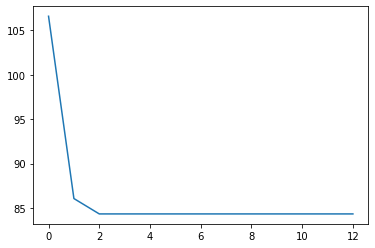

In [32]:
fig = plt.figure()
plt.plot(best_scores)
plt.show()

In [ ]:
len(best_scores)